# <img src="https://img.icons8.com/bubbles/100/000000/3d-glasses.png" style="height:50px;display:inline"> EE 046746 - Technion - Computer Vision


## Homework 3 - Features, Homographies and Panorama Stitching
---

### <a style='color:red'> Due Date: 4.1.2023 </a>

### <img src="https://img.icons8.com/bubbles/50/000000/upload-to-cloud.png" style="height:50px;display:inline"> Submission Guidelines
---
#### READ THIS CAREFULLY
* Submission only in **pairs**.
* **No handwritten submissions**.
* You can choose your working environment:
    * You can work in a `Jupyter Notebook`, locally with <a href="https://www.anaconda.com/distribution/">Anaconda</a> or online on <a href="https://colab.research.google.com/">Google Colab</a>
  * **Important**: Colab also supports running code on GPU, so if you don't have one, Colab is the way to go. To enable GPU on Colab, in the menu: `Runtime` $\rightarrow$  `Change Runtime Type` $\rightarrow$`GPU`.
    * You can work in a Python IDE such as <a href="https://www.jetbrains.com/pycharm/">PyCharm</a> or <a href="https://code.visualstudio.com/">Visual Studio Code</a>.
        * Both also allow opening/editing Jupyter Notebooks.

* Make sure you submit your exercise according to the requirements in the <a href="https://moodle.technion.ac.il/pluginfile.php/1823033/mod_resource/content/2/Homework%20guidelines.pdf">"Homework submission guidelines"</a> file that appears in the course website (Moodle). 
* **The code should run both on CPU and GPU without manual modifications**, require no special preparation and run on every computer.
* Be precise, we expect on point answers.
* Submission on the course website (Moodle).

### <img src="https://img.icons8.com/dusk/64/000000/python.png" style="height:50px;display:inline"> Python Libraries
---

* `numpy`
* `matplotlib`
* `opencv` (or `scikit-image`)
* `scikit-learn`
* `scipy`
* `torch` (and `torchvision`)
* Anything else you need (`os`, `pandas`, `csv`, `json`,...)


* **Note:** In order to work with OpenCV implementations during this exercise, please install the following versions: 

In [ ]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

### <img src="https://img.icons8.com/nolan/64/tip.png" style="height:50px;display:inline"> Important Tips
---
* You can resize the images to a lower resolution if the computation takes too long.
* You can add parameters or outputs to the defined functions and also add your own new functions if you need.

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Tasks
---
* In all tasks, you should document your process and results in a report file (which will be saved as `.pdf`). 
* You can reference your code in the report file, but no need for actual code in this file, the code is submitted in a seprate folder as explained above.

####  Introduction 
---
In this homework, we will first implement an interest point (keypoint) detector and test the performance of three common featurer descriptors. 
Then we will explore the homography between images based on the locations of the matched features. Speciﬁcally, we will look at the planar homographies. 

Why is this useful? For example, In many robotics applications, robots must often deal with tabletops, ground, and walls among other ﬂat planar surfaces. When two cameras observe a plane, there exists a relationship between the captured images. This relationship is deﬁned by a 3×3 transformation matrix, called a planar homography. 

A planar homography allows us to compute how a planar scene would look from a second camera location, given only the ﬁrst camera image. In fact, we can compute how images of the planes will look like from any camera at any location without knowing any internal camera parameters and without actually taking the pictures, all using the planar homography matrix.



#### Part 1 - Keypoint Detector
---
The first part will include implementing of keypoint detector.
In order to find keypoints, we will use the Difference of Gaussian (DoG) detector. We will use a simplified version of DoG as described in section 3 of <a href="https://people.eecs.berkeley.edu/~malik/cs294/lowe-ijcv04.pdf">[1]</a>. 

**NOTE**: The parameters to use for the following sections are:
$$\sigma_0 = 1, k =\sqrt 2, levels = [-1; 0; 1; 2; 3; 4], \theta_c = 0.03 \text{ and } \theta_r = 12$$



##### 1.1 Load Image
---
Load the `model_chickenbroth.jpg` image and show it:

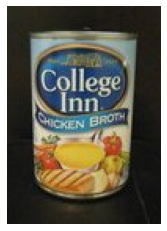

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

im = cv2.imread('data/chickenbroth/model_chickenbroth.jpg')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
_ = plt.axis('off')

##### 1.2 Gaussian Pyramid
---
Before we construct a DoG pyramid, we need to construct a Gaussian Pyramid by progressively applying a low pass Gaussian filter to the input image.
We provide you the following function `createGaussianPyramid` which gets a grayscale image with values between 0 to 1 (hint: normalize your input image and convert to grayscale). This function outputs GaussianPyramid matrix, which is a set of $L=len(levels)$ blurred images.

What is the shape of GaussianPyramid matrix?

In [ ]:
def createGaussianPyramid(im, sigma0, k, levels): 
    GaussianPyramid = []
    for i in range(len(levels)):
        sigma_ = sigma0 * k ** levels[i]
        size = int(np.floor( 3 * sigma_ * 2) + 1)
        blur = cv2.GaussianBlur(im,(size,size),sigma_)
        GaussianPyramid.append(blur)
    return np.stack(GaussianPyramid)

Use the following function to visualize your pyramid. 
* Add the results to your PDF report.

In [ ]:
def displayPyramid(pyramid): 
    plt.figure(figsize=(16,5))
    plt.imshow(np.hstack(pyramid), cmap='gray')
    plt.axis('off')

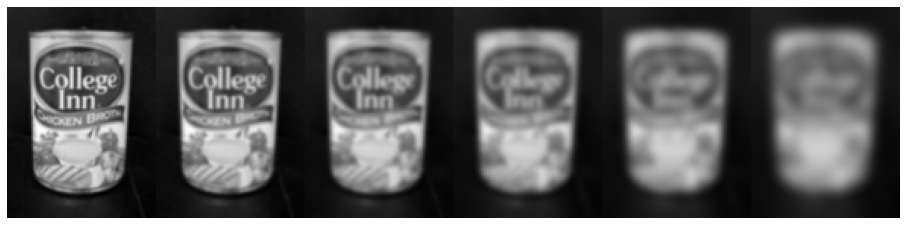

In [ ]:
# example:
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im = im / 255
sigma0 = 1
k = np.sqrt(2)
levels = [-1, 0, 1, 2, 3, 4]
GaussianPyramid =  createGaussianPyramid(im, sigma0, k, levels) 
displayPyramid(GaussianPyramid)

##### 1.3 The DoG Pyramid
---
In this section we will construct the DoG pyramid. Each level of the DoG is constructed by substructing two levels of the Gaussian pyramid:

$$D_l(x,y,\sigma_l) = (G(x,y,\sigma_{l-1})-G(x,y,\sigma_l))*I(x,y)$$

Where $G(x,y,\sigma_l)$ is the Gaussian filter used at level $l$ in the Gaussian pyramid, $I(x,y)$ is the original image, and $*$ is the *convolution* operator.

We can simplify the equation due to the distributive property of convolution:

$$D_l(x,y,\sigma_l) = G(x,y,\sigma_{l-1})*I(x,y)-G(x,y,\sigma_l)*I(x,y)=GP_{l-1}-GP_{l}$$

Where $GP_l$ is the level $l$ in the Gaussian pyramid.

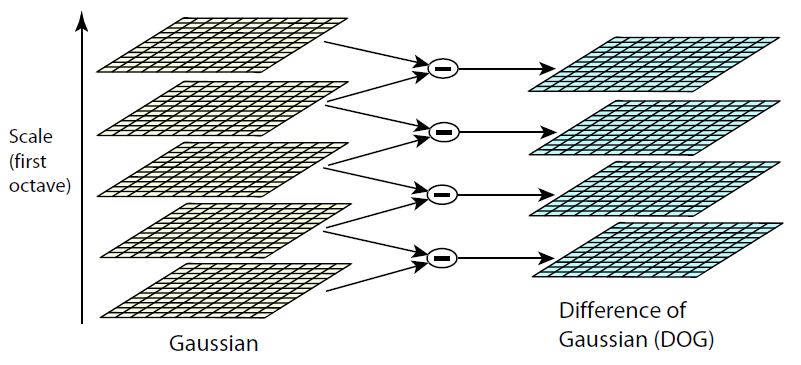

* Write the following function to constract a DoG pyramid:

In [ ]:
def createDoGPyramid(GaussianPyramid, levels):
    # Produces DoG Pyramid
    # INPUTS:
    #       GaussianPyramid     - A matrix of grayscale images of size
    #                             (len(levels), shape(im))
    #       levels              - The levels of the pyramid
    # OUTPUTS:
    #       DoGPyramid          - Size (len(levels) - 1, shape(im)) matrix of the DoG pyramid
    #                              created by differencing the Gaussian Pyramid input
    #       DogLevels           - The levels of the pyramid where the blur at each level corresponds
    #                             to the DoG scale
    """
    Your code here
    """
    return DoGPyramid, DoGLevels

This function should return DoGPyramid an $(L-1)\times imH \times imW$ matrix, where $imH\times imW$ is the original image resolution. Use `displayPyramid` to visualize the DoG pyramid, add the result to your PDF report.

##### 1.4 Edge Suppression
---
The Difference of Gaussian function responds strongly on corners and edges in addition to blob-like objects. However, edges are not desirable for feature extraction as they are not as distinctive and do not provide a substantially stable localization for keypoints.

Here, we will implement the edge removal method described in Section 4.1 of <a href="https://people.eecs.berkeley.edu/~malik/cs294/lowe-ijcv04.pdf">[1]</a>, which is based on the principal curvature ratio in a local neighborhood of a point. The paper presents the observation that edge points will have a "large principal curvature across
the edge but a small one in the perpendicular direction."


* Implement the following function:


In [ ]:
def computePrincipalCurvature(DoGPyramid):
    #  Edge Suppression
    #  Takes in DoGPyramid generated in createDoGPyramid and returns
    #  PrincipalCurvature,a matrix of the same size where each point contains the
    #  curvature ratio R for the corresponding point in the DoG pyramid
    # 
    #  INPUTS:
    #       DoGPyramid         - size (len(levels) - 1, shape(im)) matrix of the DoG pyramid
    # 
    #  OUTPUTS:
    #       PrincipalCurvature - size (len(levels) - 1, shape(im)) matrix where each 
    #                            point contains the curvature ratio R for the 
    #                            corresponding point in the DoG pyramid
    """
    Your code here
    """
    return PrincipalCurvature

The function takes in DoGPyramid generated in the previous section and returns PrincipalCurvature, a matrix of the same size where each point contains the curvature ratio R for the corresponding point in the DoG pyramid:

$ R = \frac{TR(H)^2}{Det(H)} = \frac{(\lambda_{min}+\lambda_{max})^2}{\lambda_{min}\lambda_{max}}$

where H is the Hessian of the Difference of Gaussian function (i.e. one level of the DoG pyramid) computed by using pixel differences as mentioned in Section 4.1 of <a href="https://people.eecs.berkeley.edu/~malik/cs294/lowe-ijcv04.pdf">[1]</a>. **Use the Sobel filter to  compute the second order derivatives** (hint: `cv2.Sobel()`).

$ H = \begin{bmatrix}
D_{xx} & D_{xy}\\
D_{yx} & D_{yy}
\end{bmatrix}$

This is similar in spirit to but different than the Harris corner detection matrix you saw in class. Both methods examine the eigenvalues $\lambda$ of a matrix, but the method in <a href="https://people.eecs.berkeley.edu/~malik/cs294/lowe-ijcv04.pdf">[1]</a> performs a test without requiring the direct computation of the eigenvalues. Note that you need to compute each term of the Hessian before being able to take the trace and
determinant. Feel free to implement the mathemtical formulas of $TR(H)$ and $Det(H)$ directly without explicitly building $H$. In addition, to avoid division by zero, please add a safeguard $\epsilon=10^{-8}$ to the denominator of $R$.

We can see that $R$ reaches its minimum when the two eigenvalues $\lambda_{min}$ and $\lambda_{max}$ are equal, meaning that the curvature is the same in the two principal directions. Edge points, in general, will have a principal curvature significantly larger in one direction than the other. To remove edge points, we simply check against a threshold $R > \theta_r$. In addition, in the unlikely event of a negative determinant we also discard points for which $R < 0$.
<!-- Fig. 3 shows t
he DoG detector with and without edge suppression. -->


##### 1.5 Detecting Extrema
---
To detect corner-like, scale-invariant interest points, the DoG detector chooses points that are local extrema in both scale and space. Here, we will consider a point’s eight neighbors in space and its two neighbors in scale (one in the scale above and one in the scale below).

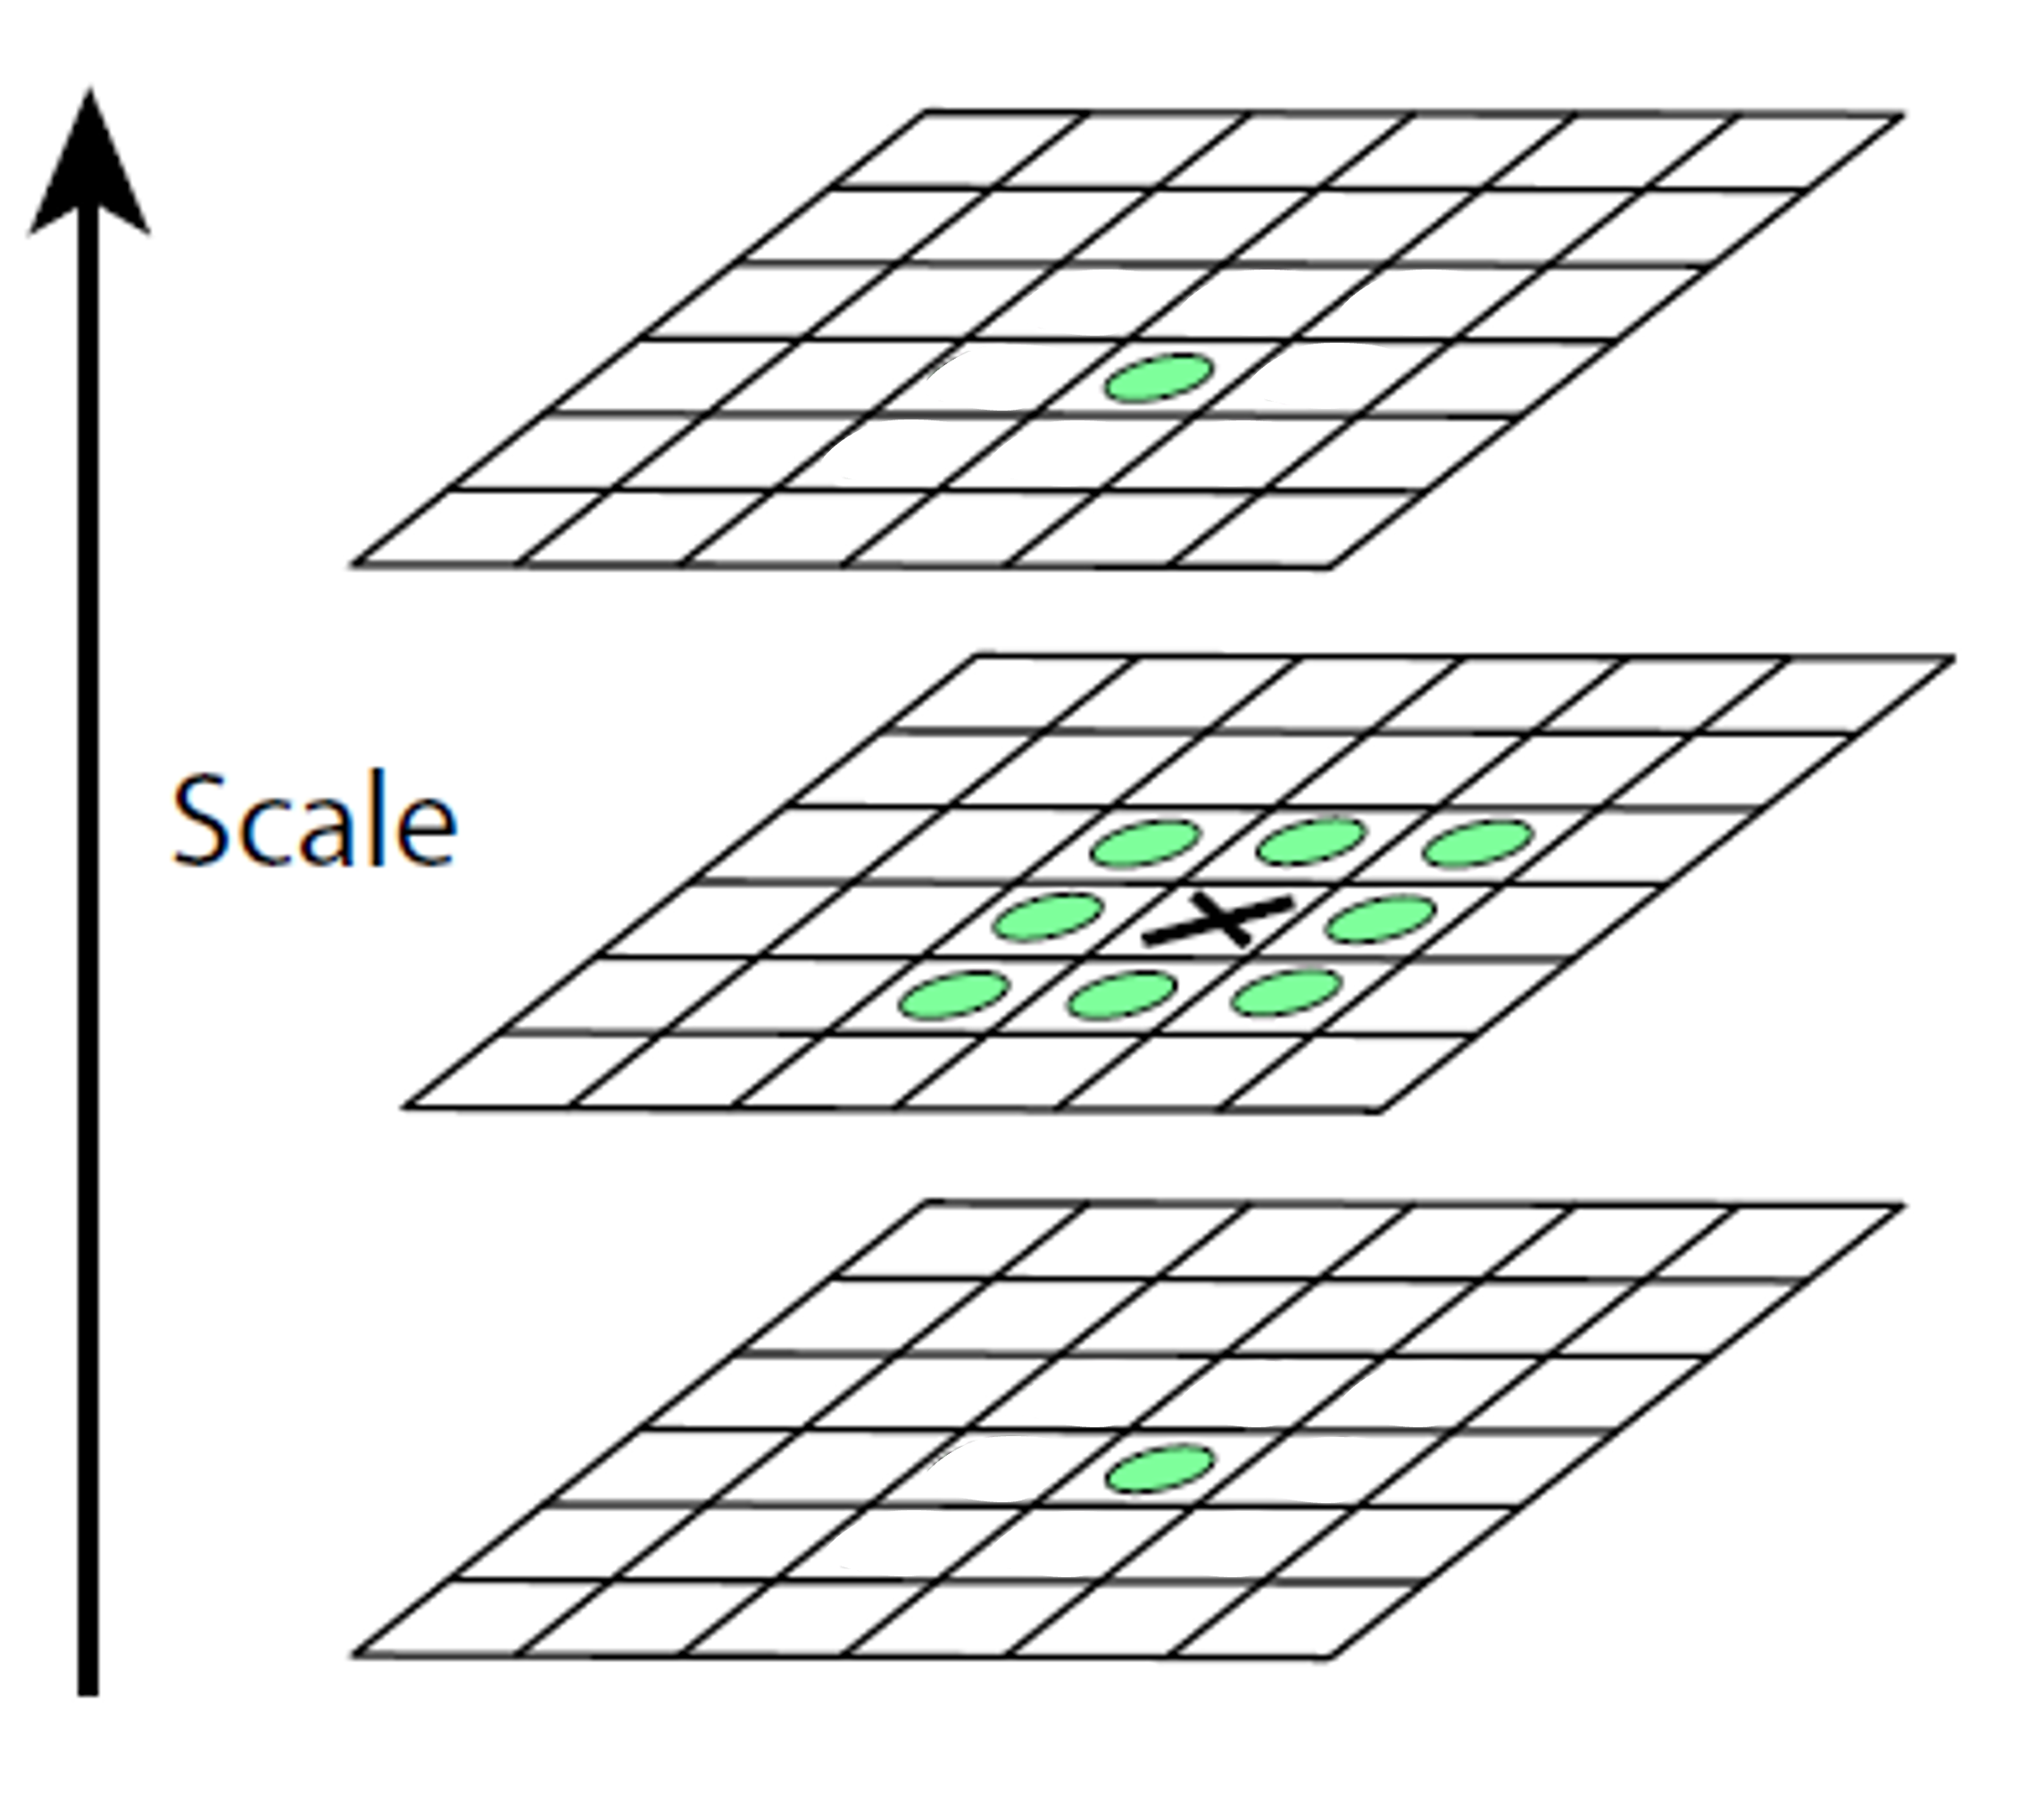

* write the function:

In [ ]:
def getLocalExtrema(DoGPyramid, DoGLevels, PrincipalCurvature,
                    th_contrast, th_r):
    # Returns local extrema points in both scale and space using the DoGPyramid
    # INPUTS
    #       DoGPyramid         - size (len(levels) - 1, imH, imW ) matrix of the DoG pyramid
    #       DoGlevels          - The levels of the pyramid where the blur at each level is
    #                            outputs
    #       PrincipalCurvature - size (len(levels) - 1, imH, imW) matrix contains the
    #                            curvature ratio R
    #       th_contrast        - remove any point that is a local extremum but does not have a
    #                            DoG response magnitude above this threshold
    #       th_r               - remove any edge-like points that have too large a principal
    #                            curvature ratio
    # OUTPUTS
    #       locsDoG            - N x 3 matrix where the DoG pyramid achieves a local extrema in both
    #                            scale and space, and also satisfies the two thresholds.
    
    """
    Your code here
    """
    return locsDoG

This function takes as input `DoGPyramid` and `DoGLevels` from Section 1.3 and `PrincipalCurvature` from Section 1.4. It also takes two threshold values, `th_contrast` and `th_r`. The threshold $\theta_c$ should remove any point that is a local extremum but does not have a Difference
of Gaussian (DoG) response magnitude above this threshold (i.e. $|D(x, y, \sigma)| > \theta_c$). The threshold $\theta_r$ should remove any edge-like points that have too large a principal curvature ratio specified by `PrincipalCurvature`.

The function should return `locsDoG`, a $N \times 3$ matrix ($N$ is the number of the detected extrema points) where the DoG pyramid achieves a local extrema in both scale and space, and also satisfies the two thresholds. The first and second column of `locsDoG` should be the $(x, y)$ values of the local extremum and the third column should contain the corresponding level of the DoG pyramid where it was detected (try to eliminate loops in the function so that it runs efficiently).

**NOTE**: In all implementations, we assume the $x$ coordinate corresponds to
columns and $y$ coordinate corresponds to rows. For example, the coordinate
$(10, 20)$ corresponds to the (row 20, column 10) in the image.




##### 1.6 Putting it Together
---
* Write the following function to combine the above parts into a DoG detector:

In [ ]:
def DoGdetector(im, sigma0, k, levels, th_contrast=0.03, th_r=12):
    #     Putting it all together
    # INPUTS
    #     im                - Grayscale image with range [0,1].
    #     sigma0            - Scale of the 0th image pyramid.
    #     k                 - Pyramid Factor.  Suggest sqrt(2).
    #     levels            - Levels of pyramid to construct. Suggest -1:4.
    #     th_contrast       - DoG contrast threshold.  Suggest 0.03.
    #     th_r              - Principal Ratio threshold.  Suggest 12.
    # OUTPUTS
    #     locsDoG           - N x 3 matrix where the DoG pyramid achieves a local extrema
    #                         in both scale and space, and satisfies the two thresholds.
    #     GaussianPyramid   - A matrix of grayscale images of size (len(levels),imH,imW)
   
    # create the gaussian pyramid
    """
    Your code here
    """
    return locsDoG, GaussianPyramid

The function should take in a grayscale image, `im`, scaled between 0 and 1, and the parameters `sigma0, k, levels, th_contrast`, and `th_r`. It should use each of the above functions and return the keypoints in `locsDoG` and the Gaussian pyramid in `GaussianPyramid`.
Note that we are dealing with real images here, so your keypoint detector may find points with high scores that you do not perceive to be corners.

* For sanity check, use the provided image `sanitycheck.jpg`. Since this image contains only simple geometrical shapes, the detection result should be a perfect detection of all corners:

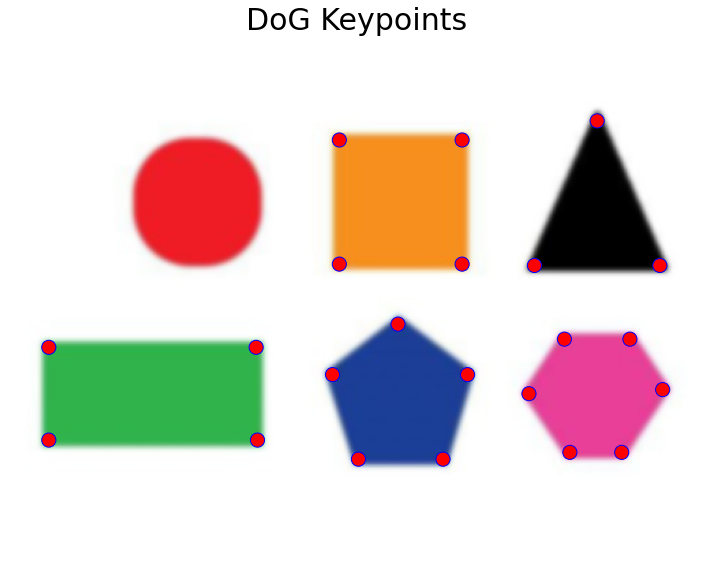

* Include the resuls obtained for `model_chickenbroth.jpg` image and another `chickenbroth` image in your PDF report. (You can use any of the provided `chickenbroth` images from the `data/chickenbroth` folder).
* Take a step outside, take a picture, and apply your keypoints detector. Do you get reasonable results? How can you improve the results? Add the result and discussion to your report.

#### Part 2 - Features Descriptor
---
In this part we are going to test three common Features Descriptor: **Binary Robust Independent Elementary Features** (BRIEF), **Oriented FAST and Rotated BRIEF** (ORB) and  **Scale-Invariant Feature Transform** (SIFT). We will use OpenCV <a href="https://docs.opencv.org/3.4/db/d27/tutorial_py_table_of_contents_feature2d.html">[2]</a> for implementation and then test their performance.

##### 2.1 Theoretical explanation
---
Briefly explain in your report how each of those descriptors works and what are their characteristics? (E.g., is it invariant to scaling, rotation, lighting change, etc.)

##### 2.2 BRIEF Implementaion
---
Implement the following function:


In [ ]:
def BRIEF_descriptor(img):
 # Returns the BRIEF descriptor and keypoints of an image, and draw its detected keypoints
 # INPUTS
 #      img                 - An image read by cv2.imread()
 # OUTPUTS
 #      brief_descriptor    - The BRIEF descrptor computed by OpenCV
 #      brief_keypoints     - The BRIEF keypoints computed by OpenCV
  
  """
  Your code here
  """
  return brief_keypoints, brief_descriptor

The function get an image ,returns its BRIEF descriptor and keypoints, and draw the detected keypoints over the image.

Plot the results obtained for the `model_chickenbroth` image and another `chickenbroth` image (You can use any of the provided `chickenbroth` images from the `data/chickenbroth` folder).

* Implementaton guidance:
    * Use `brief = cv.xfeatures2d.BriefDescriptorExtractor_create()` to instantiate the BRIEF detector. 
    * Use `fast = cv2.FastFeatureDetector_create()` as initial keypoint detector (find initial keypoints by `fast_keypoints = fast.detect(img, None)`, You can read more <a href="https://vovkos.github.io/doxyrest-showcase/opencv/sphinx_rtd_theme/page_tutorial_py_fast.html">here</a>).
    * Compute BRIEF keypoints and descriptors by `brief_keypoints, brief_descriptor = brief.compute(img, fast_keypoints)`.
    * Draw the keypoint by using `cv2.drawKeypoints()`.


##### 2.3 ORB Implementaion
---

Implement the following function:




In [ ]:
def ORB_descriptor(img):
 # Returns the ORB descriptor and keypoints of an image,and draw its detected keypoints
 # INPUTS
 #      img               - An image read by cv2.imread()
 # OUTPUTS
 #      orb_descriptor    - The ORB descrptor computed by OpenCV
 #      orb_keypoints     - The ORB keypoints computed by OpenCV
  """
  Your code here
  """
  return orb_keypoints, orb_descriptor

The function get an image ,returns its ORB descriptor and keypoints, and draw the detected keypoints over the image.

Plot the results obtained for the `model_chickenbroth` image and another `chickenbroth` image (Use the same image from previous section).

* Implementaton guidance:
    * Use `orb = cv2.ORB_create()` to instantiate the ORB detector. 
    * Detect and compute ORB keypoints and descriptors by `orb_keypoints, orb_descriptor = orb.detectAndCompute(img, None)`.
    * Draw the keypoints over the image by using `cv2.drawKeypoints()`.



##### 2.4 SIFT Implementaion
---
Implement the following function:


In [ ]:
def SIFT_descriptor(img):
 # Returns the SIFT descriptor keypoints of an image,and draw its detected keypoints
 # INPUTS
 #      img                 - An image read by cv2.imread()
 # OUTPUTS
 #      sift_descriptor     - The SIFT descrptor computed by OpenCV
 #      sift_keypoints      - The SIFT keypoints computed by OpenCV
  """
  Your code here
  """
  return sift_keypoints, sift_descriptor

The function get an image ,returns its SIFT descriptor and keypoints, and draw the detected keypoints over the image.

Plot the results obtained for the `model_chickenbroth` image and another `chickenbroth` image (Use the same image from previous section).


* Implementaton guidance:
    * Use `sift = cv2.xfeatures2d.SIFT_create()` to instantiate the SIFT detector. 
    * Detect and compute SIFT keypoints and descriptors by `sift_keypoint, sift_descriptor = sift.detectAndCompute(img,None)`.
    * Draw the keypoints over the image by using `cv2.drawKeypoints()`.


##### 2.5 Matching
---
For each one of the detectors, match between the detected keypoints of   `model_chickenbroth` and the other `chickenbroth` image you worked with. 

Match the keypoints by using OpenCV Brute-Force matcher `cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)` (<a href="https://docs.opencv.org/4.5.1/dc/dc3/tutorial_py_matcher.html">read more here</a>).

Sort the obtained matches according to their distance measure and display the first 50 matches with the shortest distance (by using `cv2.drawMatches()`).

What do you think about the results obtained? Which descriptor manages to find better matches?



#### Part 3 - Planar Homographies: 
---
After we saw how descriptors are implemented and performed, now we will see how to use them for homographis.

In this part you will implement an image stitching algorithm, and will learn how to stitch several images of the same scene into a panorama. First, we’ll concentrate on the case of two images and then extend to several images.

For the following tasks:
- **You are not allowed to use OpenCV/Scipy or any other "ready to use" functions when you are asked to implement a function (you can still use the functions to save and load images).**
- For each step add illustration images to your report.
- You can demonstrate your steps using `incline_L.jpg` and `incline_R.jpg` images, or any other relevant example images (unless specified otherwise).

#### Planar Homographies: Theory review
---
Suppose we have two cameras $C_1$ and $C_2$ looking at a common plane $Π$ in 3D space. Any 3D point $P$ on $Π$ generates a projected 2D point located at $p ≡ (x,y,1)^T$ on the ﬁrst camera $C_1$ and $q ≡ (u,v,1)^T$ on the second camera $C_2$. Since $P$ is conﬁned to the plane $Π$, we expect that there is a relationship between $p$ and $q$. In particular, there exists a common $3 × 3$ matrix $H$, so that for any $P$, the following conditions holds: 
\begin{align}
\text{(1) }q ≡ Hp
\end{align}



We call this relationship *'planar homography'*. Recall that both $p$ and $q$ are in homogeneous coordinates and the equality $≡$ means $p$ is proportional to $Hq$ (recall homogeneous coordinates). It turns out this relationship is also true for cameras that are related by pure rotation without the planar constraint. 

##### **Matched points:**
---

Given a set of points $p = \{p_1,p_2,...,p_N\}$ in an image taken by camera $C_1$ and corresponding points $q = \{q_1,q_2,...,q_N\}$ in an image taken by $C_2$. Suppose we know there exists an unknown homography $H$ between corresponding points for all $i ∈\{1,2,...,N\}$. This formally means that $\exists H$ such that: 

 
\begin{equation*} 
\text{(2) } q^i ≡ Hp^i
\end{equation*}


where $p^i = (x_i,y_i,1)$ and $q^i = (u_i,v_i,1)$ are homogeneous coordinates of image points each from an image taken with $C_1$ and $C_2$ respectively.

* Given $N$ correspondences in $p$ and $q$ and using Equation 2, we derived a set of $2N$ independent linear equations in the form:


\begin{equation*} 
\text{(3) } Ah = 0
\end{equation*}


where $h$ is a vector of the elements of $H$ and $A$ is a matrix composed of elements derived from the point coordinates:  

$$ \begin{bmatrix} &&&&&\dots\\ x_i & y_i & 1 & 0 & 0 & 0 & -x_iu_i&-y_iu_i& -u_i \\ 0&0&0&x_i&y_i&1 & -x_iv_i&-y_iv_i& -v_i \\ &&&&&\dots \end{bmatrix} 
\begin{bmatrix} h_1\\h_2\\h_3\\ h_4 \\ h_5 \\ h_6 \\ h_7\\h_8\\h_9\\ \end{bmatrix} = \begin{bmatrix} \dots \\ 0 \\ 0  \\ \dots \end{bmatrix}$$


Each point pair contributes 2 equations and therefore we need at least 4 matches.

#### Planar Homographies: Practice 
---

##### 3.1 - Finding corresponding points using SIFT: 
---
Use the guidelines from Part 2 and implement the function `getPoints_SIFT()`, which gets two images and outputs `p1,p2` SIFT keypoints, where `p1[j],p2[j]` are pairs of cooresponding points between `im1` and `im2`.

In [ ]:
def getPoints_SIFT(im1, im2):
    """
    Your code here
    """
    return p1,p2

Inputs: `im1` and `im2` are two 2D grayscale images. 

Output: `p1` and `p2` should be $2\times N$ matrices of corresponding $(x,y)^T$ coordinates between two images ($N$ is the number of corrosponding points you want to extract.). 

* You can also use color images instead of grayscale images, just state it in the report.

#### 3.2 - Calculate transformation: 
---

Implement a function that gets a set of matching points between two images and calculates the transformation between them. The transformation should be $3\times3$ $H$ homogenous matrix such that for each point in image $p\in C_1$, there would be a transformation in image $C_2$ such that $p=Hq$, $q\in C_2$.

In [ ]:
def computeH(p1, p2):
    """
    Your code here
    """
    return H2to1

Inputs: `p1` and `p2` should be $2\times N$ matrices of corresponding $(x,y)^T$ coordinates between two images. 

Outputs: `H2to1` should be a $3\times 3$ matrix encoding the homography that best matches the linear equation derived above for Equation 2. 

Hint: Remember that a homography is only determined up to scale. The `numpy`'s functions `eig()` or `svd()` will be useful. Note that this function can be written without an explicit for-loop over the data points.

*Hint for debugging*: A good test of your code is to check that the homography of an image with itself is an identity.

* Implement the computation function, describe and explain your implementation.
* Show that the transformation is correct by selecting arbitrary points in the first image and projecting them to the second image.

#### 3.3 - Image warping:
---
Implement a function that gets an input image and a transformation matrix H and returns the warped image. Please note that after the warping, there will be coordinates that won’t be integers (e.g. sub-pixels). Therefore you will need to interpolate between neighboring pixels. For color images, warp the image for each color channel and then connect them together. In order to avoid holes, use inverse warping.

Implement the wrapping function using numpy and SciPy interp2d() or RegularGridInterpolator() function .
Discuss the influences of different interpolations kinds {‘linear’, ‘cubic’}.
Note: When performing a multi-step algorithm, you need to demonstrate and explain each of those additional improvments.


In [ ]:
def warpH(im1, H, out_size):
    """
    Your code here
    """
    return warp_im1

Inputs: `im1` is a colored image. `H` is a  matrix encoding the homography between im1 and im2. `out_size` is the size of the wanted output (new_imH,new_imW).

Output: `warp_im1` is the warped image im1 including empty background (zeros).

##### 3.4 - Panorama stitching: 
---
Implement a function that gets two images after axis alignment (using OpenCV's `warpPerspective`)
and returns a union of the two. The union should be a simple overlay of one image on the other. Leave empty pixels painted black.


In [ ]:
def imageStitching(img1, warp_img2):
    """
    Your code here
    """
    return panoImg
    

Inputs: `im1`,`warp_img2` are two colored images. 

Output: `panoImg` is the gathered output  panorama.

* Use all the above functions to create a panorama image. Demonstrate and explain you results on the `./data/incline` images.

##### 3.5 - Several Images stitching:
---
* Show the results of the panoramas on the attached images of the beach (`./data/beach`) and Pena National Sintra Palace (`./data/sintra`) for the entire set of images.

* Note: When using SIFT without RANSAC (next section), take the top K matches for estimating the homography. 
  * What happens if you don't do so? Why is that?

##### 3.6 - RANSAC:
---
Added bellow is an implementation of the RANSAC (**Ran**dom **Sa**mple **C**onsensus) algorithm. 
* Explain when it is needed and why.
* Copmare between using RANSAC vs. not using it for creating the panoran images of the beach and SINTRA. Explain.
* What could have been done to get better results?

In [ ]:
def ransacH(p1, p2, nIter=..., tol=...):
    N = p1.shape[1]
    stacked_p2 = np.vstack((p2, np.ones(N)))

    best_inliers_n = 0
    best_inliers = []

    for iter in range(nIter):
        rand_idxs = np.random.choice(np.arange(N), 4, replace=False)
        chosen_p1 = p1[:, rand_idxs]
        chosen_p2 = p2[:, rand_idxs]
        H2to1 = computeH(chosen_p1, chosen_p2)
        p2in1 = H2to1 @ stacked_p2
        p2in1 = p2in1 / p2in1[2, :]
        p2in1 = p2in1[0:2, :]
        L2dists = np.sqrt(np.sum((p2in1 - p1) ** 2, 0))
        inliers = (p1[:, L2dists < tol], p2[:, L2dists < tol])
        n_inliers = np.sum(L2dists < tol)
        if n_inliers > best_inliers_n:
            best_inliers_n = n_inliers
            best_inliers = inliers

    bestH = computeH(best_inliers[0], best_inliers[1])
    return bestH

Inputs: 
* `p1` and `p2` are matrices specifying point locations in each of the images and `p1[j]`,`p2[j]` are matched points between two images.

* `nIter` is the number of iterations to run RANSAC  

* `tol` is the tolerance value for considering a point to be an inlier. 

 * Define your function so that these  `nIter` and  `tol` have reasonable default values.

Outputs: 
* `bestH` is the homography model with the most inliers found during RANSAC

##### 3.7 - Be Creative:
---
* Go out and take at least 3 pictures of a far distance object (e.g. a building), and use what you have learned to create a new excellent Panorama image.
  * Add the resulted image to your report and to the `output` folder.

#### Part 4 - Dry Questions
---
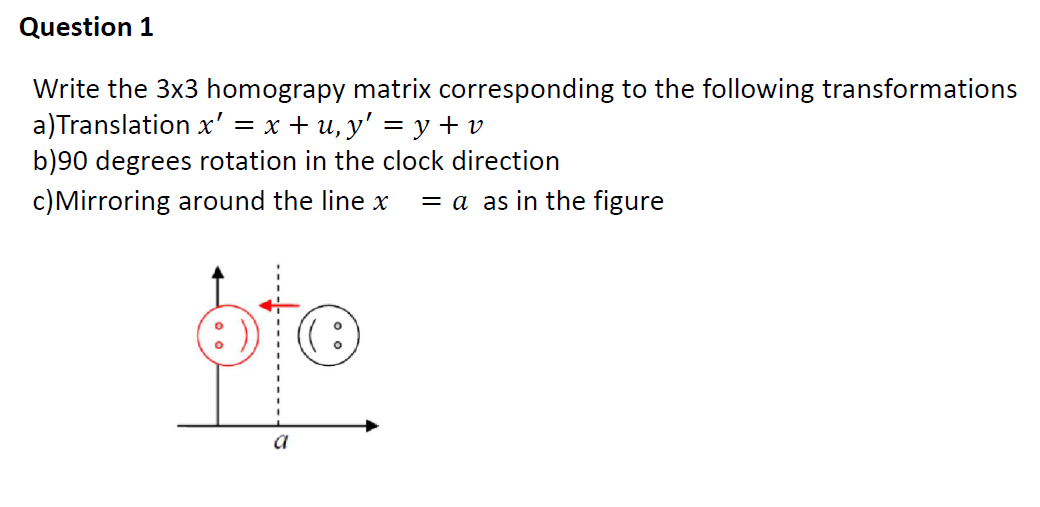



## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> References & Credits
* Carnegie Mellon University - CMU
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com